# Thesis Hierarchical plots - 2try - Sparsity version

2/X

Sparse version now.

Randomly varying 2 parameters:
- p / sparsity
- theta / threshold for second layer ReLU.

In [109]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
import os
import numpy as np
import scipy as sp
import scipy.stats as spst
import scipy.interpolate as spint
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.utils import io
import progress
import collections
import cPickle as pickle

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa

import hierarchicalrandomnetwork

# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})

In [127]:
overwrite = False
cache_filename = ("/nfs/data3/lmatthey/visual_working_mem/hierarchical_network_characterisation/"
                  "hierarchical_weights_ptheta_2try_repetitions10_280818/outputs/df_out.pkl")

if os.path.exists(cache_filename) and not overwrite:
    import reloader_hierarchical_weights_2try_280818 as rel
    generator_module = rel.generator_module
    dataset_infos = rel.dataset_infos
    df_all_fits = pd.read_pickle(cache_filename)
else:
    with io.capture_output(display=False, stdout=True) as captured:
        %run reloader_hierarchical_weights_2try_280818.py
        
    dataset_infos = data_pbs.dataset_infos

In [112]:
dataio = DataIO(output_folder=generator_module.pbs_submission_infos['simul_out_dir'] + '/outputs/', 
                label='thesis_' + dataset_infos['save_output_filename'])
dataio.make_link_output_to_dropbox(dropbox_current_experiment_folder='hierarchicalrandomnetwork_characterisation')

=== FileIO ready: /nfs/data3/lmatthey/visual_working_mem/hierarchical_network_characterisation/hierarchical_weights_ptheta_2try_repetitions10_280818/outputs/thesis_hier_params-<module>-e9a3a008-622d-4e47-858f-1d0183497e06 ===
Doing dropbox symlink:  /nfs/data3/lmatthey/visual_working_mem/hierarchical_network_characterisation/hierarchical_weights_ptheta_2try_repetitions10_280818/outputs/ /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/hierarchicalrandomnetwork_characterisation/hierarchical_weights_ptheta_2try_repetitions10_280818_outputs
Symlink failed:  /nfs/data3/lmatthey/visual_working_mem/hierarchical_network_characterisation/hierarchical_weights_ptheta_2try_repetitions10_280818/outputs/ /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/hierarchicalrandomnetwork_characterisation/hierarchical_weights_ptheta_2try_repetitions10_280818_outputs

In [113]:
# Processing data 
def avg_axis(array_name, array, axis=None, out=None):
    if out is None:
        out = []
    out.append((array_name, np.mean(array, axis=axis)))
    return out

def process_inv_var(array_name, array):
    out = []
    avg_axis(array_name, array, out=out)
    avg_axis(array_name + "_stddev", (1./array)**0.5, out=out)
    return out
    
def process_marginal_fi(array_name, array):
    out = []
    
    # Marginal FI/Inv FI have (mean, std), just keep mean
    array = array[..., 0]
    avg_axis(array_name, array, out=out)
    
    if array_name.find('inv') > -1:
        avg_axis(array_name + "_stddev", (1.*array)**0.5, out=out)
    else:
        avg_axis(array_name + "_stddev", (1./array)**0.5, out=out)
    
    return out

def process_em_fits(array_name, array):
    out = []
    for col_i, colname in enumerate(
            ['kappa', 'target', 'nontargets', 'random', 'LL', 'bic']):
        out = avg_axis(array_name + "_" + colname, array[col_i], out=out)
        
    out = avg_axis(array_name + '_fidelity', 1./utils.kappa_to_stddev(array[0])**2., out=out)
    out = avg_axis(array_name + '_stddev', utils.kappa_to_stddev(array[0]), out=out)
    
    return out

def construct_pandas_dataframe_flat(data_pbs, pandas_columns_with_processing, num_repetitions, overwrite=False):    
    parameter_names_sorted = data_pbs.dataset_infos['parameters']
    num_samples = len(data_pbs.loaded_data['datasets_list'])
    pandas_column_data = collections.defaultdict(list)

    load_progress = progress.Progress(num_samples)
    for i in xrange(num_samples):
        # For every sample, need to add a row with all columns
        if i % (num_samples/10) == 0:
            print "{:.1f}% {}".format(load_progress.percentage(), load_progress.time_remaining_str())

        # Extract data
        for repet_i in xrange(num_repetitions):
            # Filter completed only
            repeats_completed = data_pbs.dict_arrays.values()[0]['repeats_completed'][i]
            if repeats_completed != (num_repetitions - 1):
                continue

            for result_array_name, result_processing in pandas_columns_with_processing:
                res_array = np.array(data_pbs.dict_arrays[result_array_name]['results_flat'][i])[..., repet_i]

                columns_data = result_processing['process'](result_processing['name'], res_array)
                for column_name, col_data in columns_data:
                    pandas_column_data[column_name].append(col_data)

            pandas_column_data['repet'].append(repet_i)
            for param_i, param_name in enumerate(parameter_names_sorted):
                pandas_column_data[param_name].append(
                    data_pbs.dict_arrays[result_array_name]['parameters_flat'][i][param_i])

        load_progress.increment()

    df_out = pd.DataFrame(pandas_column_data)
    return df_out

In [114]:
def remove_outliers(df, n_stddev=5):
    outliers = np.sum(np.abs(spst.zscore(df)) < n_stddev, axis=-1)
    return df[outliers >= outliers.max()]

def df_add_quantize_parameters(df, parameters, nQuantiles):
    param_qbins = dict()
    param_qbins_middle = dict()

    for param_name in parameters:
        param_factored, param_qbins[param_name] = pd.cut(df[param_name], nQuantiles, retbins=True, labels=False)
        param_qbins[param_name] = np.unique(param_qbins[param_name])
        param_qbins_middle[param_name] = ((param_qbins[param_name][:-1] + param_qbins[param_name][1:])/2.
                                         ).astype(df[param_name].dtype)
        df.loc[:, (param_name + "_qi")] = param_factored
    
    return df, param_qbins, param_qbins_middle

def filter_dataframe(df, parameters_values):
    filter_mask = None
    for key, value in parameters_values.iteritems():
        new_filter = (df[key] == value)
        if filter_mask is None:
            filter_mask = new_filter
        else:
            filter_mask = filter_mask & new_filter
    
    if filter_mask is None:
        return df
    else:
        return df[filter_mask]

def filter_quantized_param(df, target_parameters, param_qbins):
    quantized_parameters_targets = dict()
    
    for key, value in target_parameters.iteritems():
        target_qi = (np.digitize(value, param_qbins[key], right=False).item() - 1)
        quantized_parameters_targets[key + "_qi"] = target_qi
        
    return filter_dataframe(df, quantized_parameters_targets)

In [115]:
# Extract data
num_repetitions = generator_module.num_repetitions
parameter_names_sorted = dataset_infos['parameters']

if not os.path.exists(cache_filename) or overwrite:
    pandas_columns_with_processing = [
        ('result_all_precisions', dict(name='precision', process=process_inv_var)),
        ('result_FI_rc_curv', dict(name='fi_curv', process=process_inv_var)),
        ('result_em_fits', dict(name='emfit', process=process_em_fits)),
    ]

    df_all_fits = construct_pandas_dataframe_flat(data_pbs, pandas_columns_with_processing, num_repetitions)
    df_all_fits.to_pickle(cache_filename)
else:
    df_all_fits = pd.read_pickle(cache_filename)

0.0% --
10.0% 26s
20.0% 22s
30.0% 19s
40.0% 17s
50.0% 14s
60.0% 11s
70.0% 8s
80.0% 6s
90.0% 3s


In [116]:
# df_all_fits.loc[:, ('ratio_fi_fidelity')] = df_all_fits['fi_theo']/(2*df_all_fits['emfit_fidelity'])
# df_all_fits.loc[:, ('ratio_fi_fidelity_error')] = df_all_fits['ratio_fi_fidelity'] - 1.
# df_all_fits.loc[:, ('ratio_fi_stddev')] = df_all_fits['fi_theo_stddev']/(df_all_fits['emfit_stddev'])
# df_all_fits.loc[:, ('ratio_margfi_stddev')] = df_all_fits['inv_fi_marginal_stddev']/(df_all_fits['emfit_stddev'])

# Filter a bit
# df_fits_filtered = df_all_fits
df_fits_filtered = df_all_fits.dropna()
df_fits_filtered = df_fits_filtered[df_fits_filtered.emfit_fidelity < 500]
# df_fits_filtered = df_fits_filtered[df_all_fits['inv_fi_marginal_stddev'] < 1.]

sparsity_space = np.sort(df_fits_filtered['sparsity'].unique())
threshold_space = np.sort(df_fits_filtered['threshold'].unique())

In [117]:
# Remove outliers
df_fits_filtered = remove_outliers(df_fits_filtered, 5)

In [118]:
df_fits_filtered.describe()

,emfit_LL,emfit_bic,emfit_fidelity,emfit_kappa,emfit_nontargets,emfit_random,emfit_stddev,emfit_target,fi_curv,fi_curv_stddev,precision,precision_stddev,repet,sparsity,threshold
count,95017.000000,95017.000000,95017.000000,95017.000000,95017.0,95017.000000,9.501700e+04,95017.000000,95017.000000,95017.000000,95017.000000,95017.000000,95017.000000,95017.000000,95017.000000
mean,-274.917512,571.028293,58.128127,58.631116,0.0,0.641026,inf,0.358974,237.510438,0.120607,1.226432,1.513756,4.500405,0.074219,4.866266
std,104.960146,209.920292,48.965165,48.965954,0.0,0.242990,NaN,0.242990,180.275430,0.048067,3.534882,0.533496,2.872022,0.043009,2.858622
min,-367.576222,-280.176525,0.000000,0.000000,0.0,0.005679,5.325185e-02,0.000000,7.792033,0.045778,0.065563,0.179506,0.000000,0.000001,0.000120
25%,-350.305106,489.922410,28.840409,29.347873,0.0,0.479501,1.189180e-01,0.160414,126.270724,0.089490,0.277430,1.141647,2.000000,0.036804,2.398744
50%,-312.055487,645.304244,45.010494,45.515219,0.0,0.697200,1.490538e-01,0.302800,175.748106,0.105740,0.423006,1.537541,4.000000,0.073577,4.789822
75%,-234.364570,721.803481,70.713877,71.216861,0.0,0.839586,1.862084e-01,0.520499,281.075991,0.133057,0.767249,1.898554,7.000000,0.111696,7.294945
max,150.684897,756.345714,352.639186,353.139779,0.0,1.000000,inf,0.994321,1157.862861,0.382295,31.034204,3.905458,9.000000,0.149989,9.999172


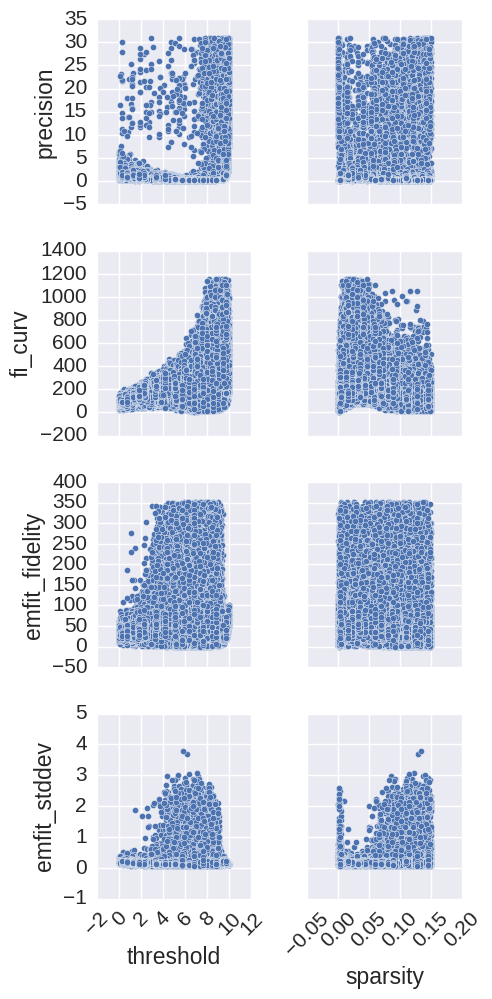

In [119]:
# Cross-correlation plots
g = sns.pairplot(
    df_fits_filtered,
    x_vars=parameter_names_sorted,
    y_vars=['precision', 'fi_curv', 'emfit_fidelity', 'emfit_stddev']
)
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)

## Quantize and do some plots

In [120]:
nQuantiles = 31

df_quantized, param_qbins, param_qbins_middle = df_add_quantize_parameters(
    df_fits_filtered, parameter_names_sorted, nQuantiles)

## 2D plot M/ratio_conj

In [121]:
def plot_mean_std_df(df, x_col, y_col, param_qbins_middle, xlabel=None, ylabel=None, ax=None):
    df_mean = df.groupby(x_col + "_qi").mean()
    df_std = df.groupby(x_col + "_qi").std()
    
    return utils.plot_mean_std_area(df_mean[x_col], #param_qbins_middle[x_col], 
                                    df_mean[y_col],
                                    df_std[y_col],
                                    xlabel=xlabel,
                                    ylabel=ylabel,
                                    ax_handle=ax,
                                    label=y_col
                                   )

In [122]:
def compute_spline_interpolation(df, interpolate_column, x_col='', y_col='', kx=3, ky=3, s=None):
    
    if interpolate_column + "_std" in df:
        w = 1./df[interpolate_column + "_std"]
    else:
        w = None
        
    return spint.SmoothBivariateSpline(df[x_col], df[y_col], df[interpolate_column], w=w, kx=kx, ky=ky, s=s)

def pcolor_2d_interpolated(df, target_column, x_col='M', y_col='rc_scale', x_int_space=None, y_int_space=None,
                           title='', vmin=None, vmax=None, cmap='RdBu_r'):
    if x_int_space is None:
        x_int_space = np.sort(df[x_col].unique())
    if y_int_space is None:
        y_int_space = np.sort(df[y_col].unique())

    spline_int = compute_spline_interpolation(df, target_column, 
                                              x_col=x_col, y_col=y_col)
    return utils.pcolor_2d_data(spline_int(x_int_space, y_int_space),
                                x=x_int_space, 
                                y=y_int_space, 
                                xlabel=x_col, 
                                ylabel=y_col, 
                                title=title,
                                ticks_interpolate=15,
                                vmin=vmin,
                                vmax=vmax,
                                log_scale=False, 
                                cmap=cmap
                               )

In [123]:
df_avgstd = df_quantized.groupby(parameter_names_sorted, as_index=False).agg(('mean', 'std')).reset_index()
df_avgstd.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df_avgstd.columns.values]
df_avgstd.columns = [s.split('_mean')[0] for s in df_avgstd.columns]


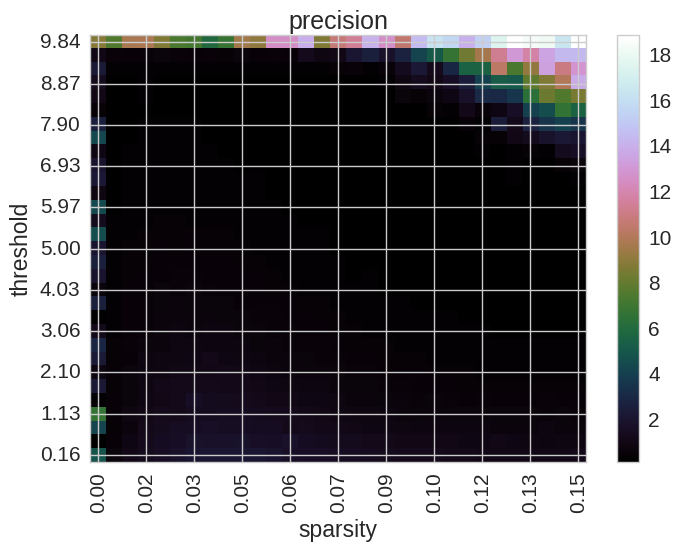

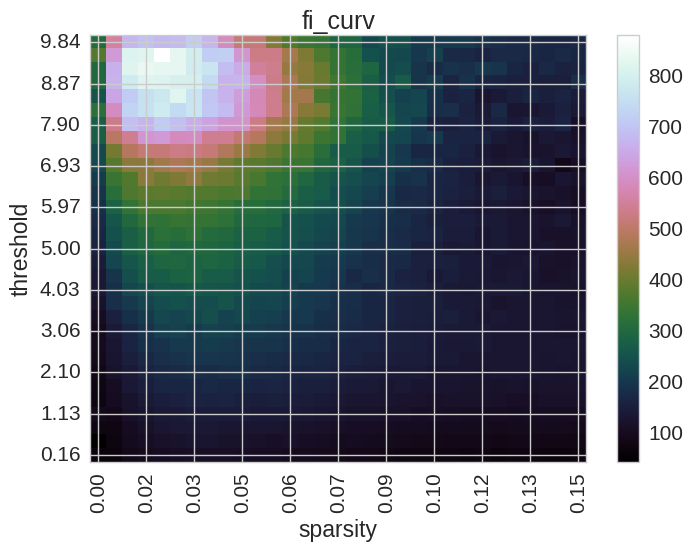

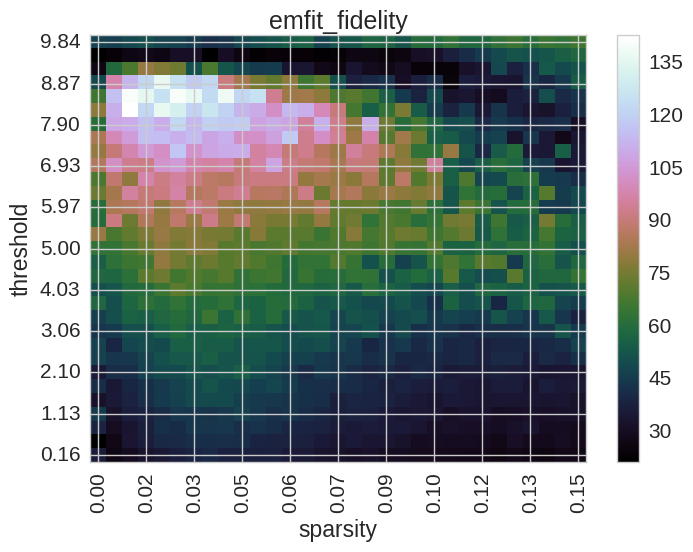

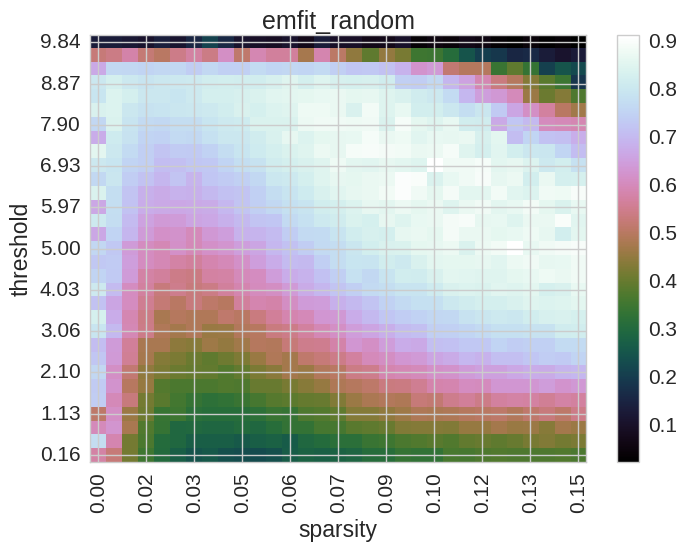

In [124]:
values = ['precision', 'fi_curv', 'emfit_fidelity', 'emfit_random']

for value in values:
    params = ('sparsity', 'threshold')
    data_pivot = df_avgstd.pivot_table(index="{}_qi".format(params[0]), columns="{}_qi".format(params[1]), 
                                       values=value).as_matrix()
    with sns.axes_style('whitegrid'):
        utils.pcolor_2d_data(data_pivot, x=param_qbins_middle[params[0]], y=param_qbins_middle[params[1]], 
                             ticks_interpolate=11, cmap='cubehelix', xlabel=params[0], ylabel=params[1], 
                             title=value)

    # dataio.save_current_figure("fisher_fidelity_ratio_deviation_2d_white.pdf")

# Threshold > 3 just gives random results. Let's filter down

In [128]:
df_fits_filtered_f3 = df_fits_filtered[df_fits_filtered.threshold < 2]
# df_fits_filtered_f3 = df_fits_filtered_f3[df_fits_filtered_f3.emfit_random < 0.3]

nQuantiles = 21

df_quantized_f3, param_qbins_f3, param_qbins_middle_f3 = df_add_quantize_parameters(
    df_fits_filtered_f3, parameter_names_sorted, nQuantiles)
df_avgstd_f3 = df_quantized_f3.groupby(parameter_names_sorted, as_index=False).agg(('mean', 'std')).reset_index()
df_avgstd_f3.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df_avgstd_f3.columns.values]
df_avgstd_f3.columns = [s.split('_mean')[0] for s in df_avgstd_f3.columns]


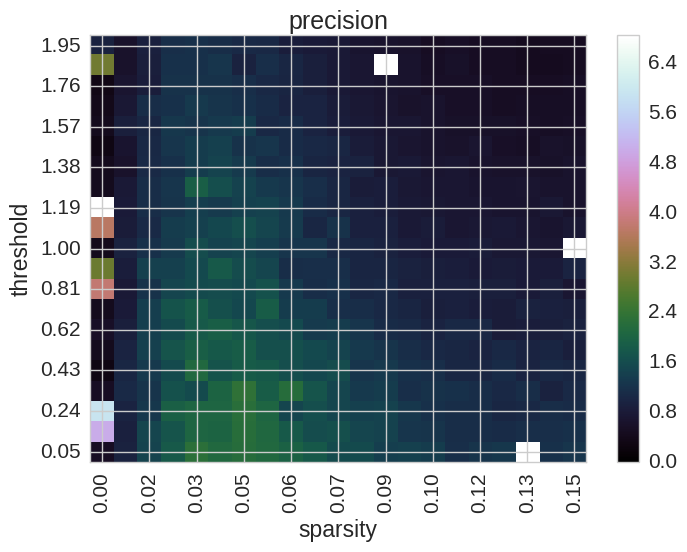

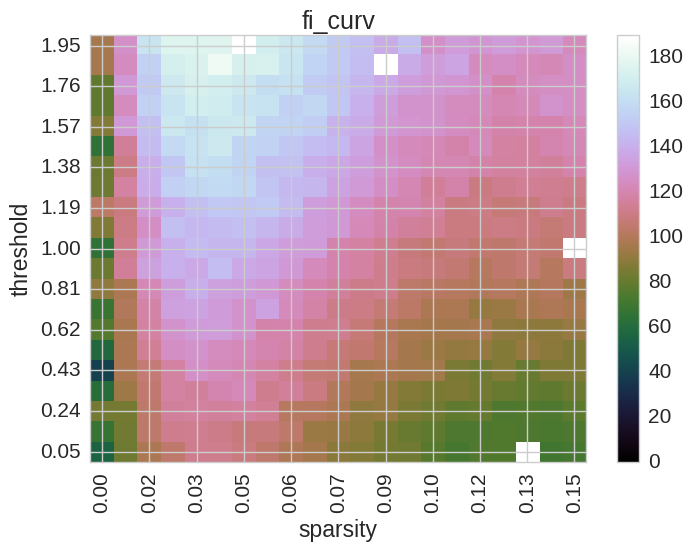

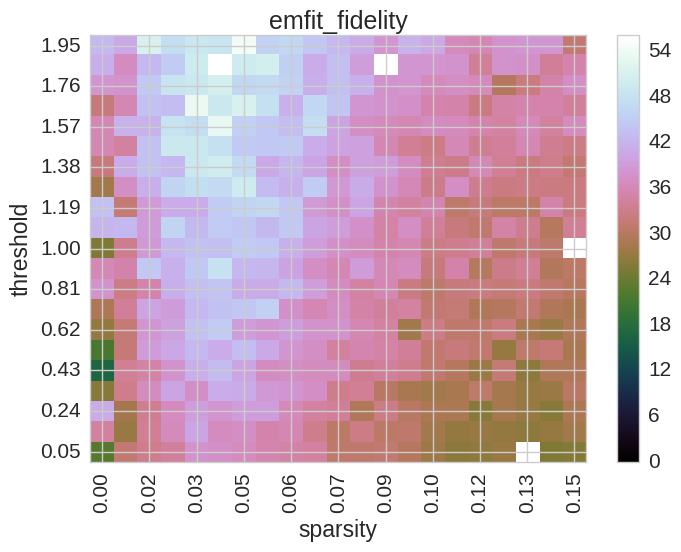

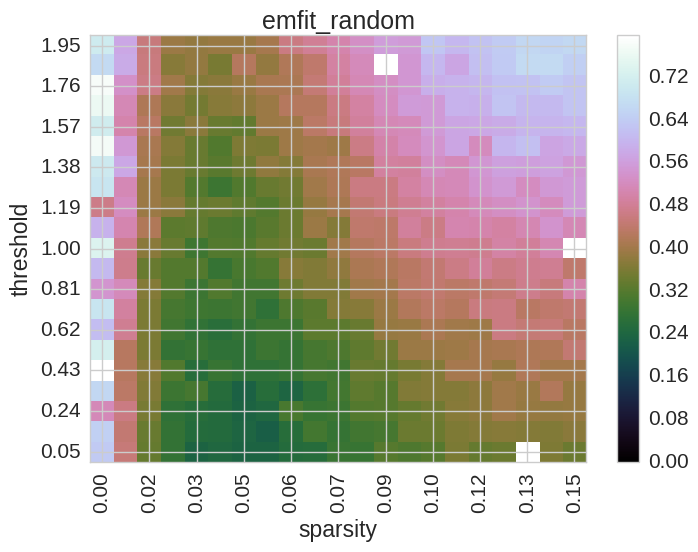

In [132]:
values = ['precision', 'fi_curv', 'emfit_fidelity', 'emfit_random']

for value in values:
    params = ('sparsity', 'threshold')
    data_pivot = df_avgstd_f3.pivot_table(index="{}_qi".format(params[0]), columns="{}_qi".format(params[1]), 
                                          values=value).as_matrix()
    with sns.axes_style('whitegrid'):
        utils.pcolor_2d_data(data_pivot, x=param_qbins_middle_f3[params[0]], y=param_qbins_middle_f3[params[1]], 
                             ticks_interpolate=11, cmap='cubehelix', xlabel=params[0], ylabel=params[1], 
                             title=value, vmin=0)

    # dataio.save_current_figure("fisher_fidelity_ratio_deviation_2d_white.pdf")

In [131]:
# Save it to merge it back into 1try
filename = dataio.create_formatted_filename("data_df_sparse.pkl")
df_fits_filtered_f3.to_pickle(filename)
print "Saved at", filename

Saved at /nfs/data3/lmatthey/visual_working_mem/hierarchical_network_characterisation/hierarchical_weights_ptheta_2try_repetitions10_280818/outputs/data_df_sparse.pkl


==> I'm pretty sure some angles aren't stored.

Need to show this somehow.